In [1]:
!pip install seaborn catboost -q
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv("train.csv")

train (2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
2218,e19946044s,VW Polo VI,economy,petrol,4.16,2014,74942,2015,33.41,wheel_shake,4.582644,1.601449e+07,0.19,133.755493,-8.077716,174,173
1937,H41383708k,Hyundai Solaris,economy,petrol,4.00,2014,55426,2015,64.58,another_bug,4.805460,1.183871e+07,0.10,187.436289,5.925098,174,171
1623,C-1160143Y,Kia Sportage,standart,petrol,5.52,2012,27077,2015,35.12,break_bug,5.129310,1.205279e+07,0.19,109.836914,0.705304,174,173


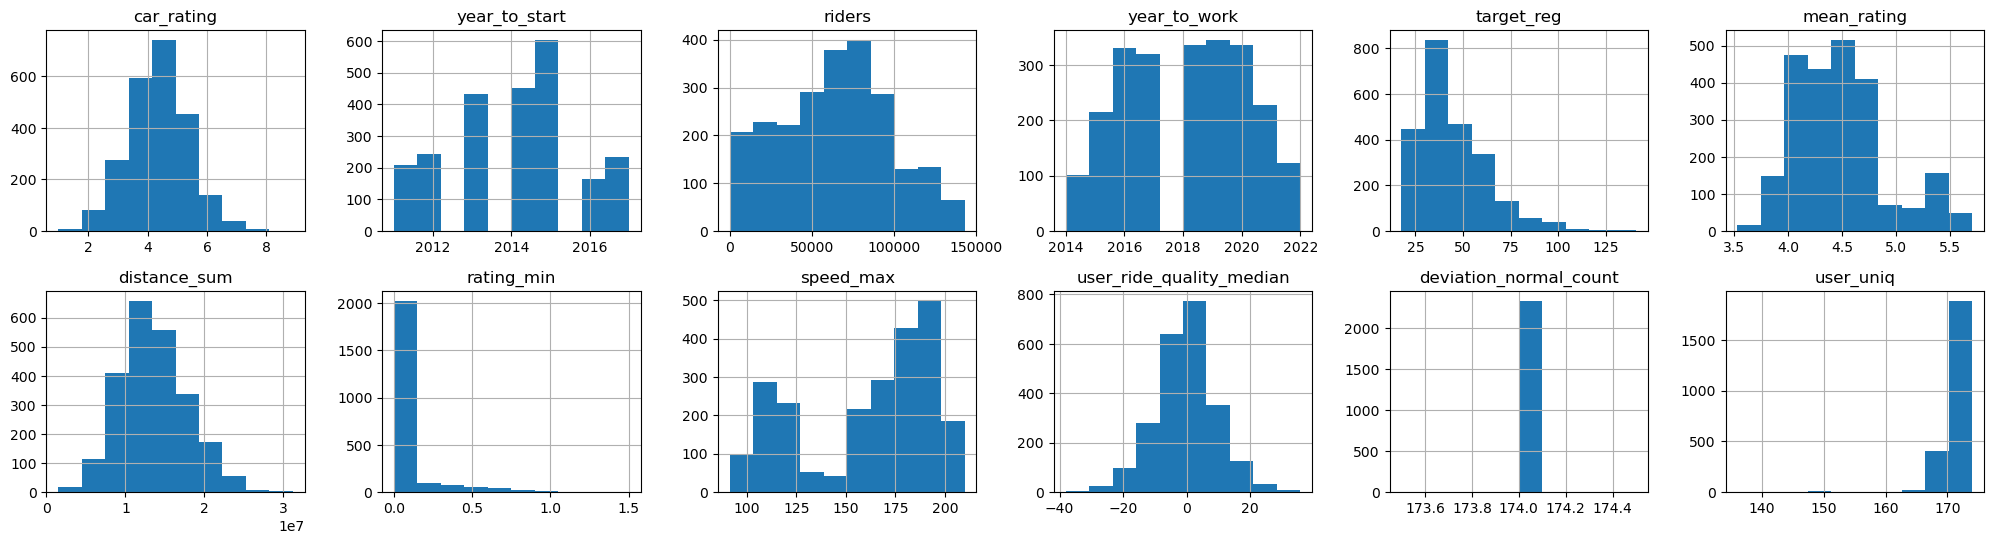

In [3]:
print("train", train.shape)
train.hist(figsize=(25, 6), layout=(-1, 6))
train.sample(3)

In [4]:
cat_features = ["model", "car_type", "fuel_type"]  # Выделяем категориальные признаки
targets = ["target_class", "target_reg"]
features2drop = ["car_id", "target_reg"]  # эти фичи будут удалены

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", targets)

for c in cat_features:  # Избавлеямся от NaN'ов
    train[c] = train[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 11
targets ['target_class', 'target_reg']


In [5]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## CatBoost

In [6]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from scipy import stats

In [7]:
catBoostReg = CatBoostRegressor(    
        cat_features=cat_features,
        task_type="CPU")

catBoostReg.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=500,
        use_best_model=True,
        plot=False)

print(catBoostReg.best_score_)

Learning rate set to 0.056174
0:	learn: 17.1114797	test: 17.8473672	best: 17.8473672 (0)	total: 128ms	remaining: 2m 8s
500:	learn: 7.3441758	test: 12.4335676	best: 12.1585875 (158)	total: 7s	remaining: 6.98s
999:	learn: 5.2987756	test: 12.6087656	best: 12.1585875 (158)	total: 13.1s	remaining: 0us

bestTest = 12.15858747
bestIteration = 158

Shrink model to first 159 iterations.
{'learn': {'RMSE': 5.29877563377732}, 'validation': {'RMSE': 12.158587472625873}}


### Тюнинг

In [8]:
catBoostReg = CatBoostRegressor(
        depth=4,
        iterations=3500,
        learning_rate=0.07,
        cat_features=cat_features,
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=4,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        random_seed=7501)

catBoostReg.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=500,
        plot=False)

print(catBoostReg.best_score_)

0:	learn: 17.0957722	test: 17.8262492	best: 17.8262492 (0)	total: 1.07ms	remaining: 3.76s
500:	learn: 10.2582985	test: 12.0334451	best: 11.9962206 (436)	total: 842ms	remaining: 5.04s
1000:	learn: 9.4229140	test: 12.0239272	best: 11.9924648 (722)	total: 1.6s	remaining: 4s
1500:	learn: 8.7445266	test: 12.1114167	best: 11.9924648 (722)	total: 2.43s	remaining: 3.24s
2000:	learn: 8.0972114	test: 12.2430268	best: 11.9924648 (722)	total: 3.51s	remaining: 2.63s
2500:	learn: 7.6439763	test: 12.3048302	best: 11.9924648 (722)	total: 4.48s	remaining: 1.79s
3000:	learn: 7.2216722	test: 12.3849957	best: 11.9924648 (722)	total: 5.24s	remaining: 871ms
3499:	learn: 6.9090305	test: 12.4373696	best: 11.9924648 (722)	total: 5.95s	remaining: 0us

bestTest = 11.99246485
bestIteration = 722

Shrink model to first 723 iterations.
{'learn': {'RMSE': 6.909030450972933}, 'validation': {'RMSE': 11.992464845430538}}


In [9]:
test = pd.read_csv('test.csv')
x_test = test[filtered_features].drop(targets, axis=1, errors="ignore")

y_pred = catBoostReg.predict(x_test)
predictions_df = pd.DataFrame({'car_id': test['car_id'], 'target_class': y_pred})
predictions_df.to_csv('catBoostReg_predictions.csv')

## XGBoost

In [10]:
!pip install xgboost -q
import xgboost as xgb
import warnings; warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [11]:
train = pd.read_csv('train.csv')
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

X = train.drop(drop_cols, axis=1)
y = train['target_reg']

In [12]:
# Кат фичи преведем в тип 'category'
for col in cat_cols:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.metrics import mean_poisson_deviance

xgbreg = xgb.XGBRegressor(tree_method="hist",
                       eval_metric = mean_poisson_deviance,
                       enable_categorical=True,
                       n_estimators=30, n_jobs=-1
)
xgbreg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=10,
        verbose=3)

y_pred = xgbreg.predict(X_test, iteration_range=(0, xgbreg.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

[0]	validation_0-rmse:15.73818	validation_0-mean_poisson_deviance:4.83291
[3]	validation_0-rmse:13.04271	validation_0-mean_poisson_deviance:3.25132
[6]	validation_0-rmse:12.64687	validation_0-mean_poisson_deviance:3.07632
[9]	validation_0-rmse:12.65160	validation_0-mean_poisson_deviance:3.07671
[12]	validation_0-rmse:12.67780	validation_0-mean_poisson_deviance:3.08867
[15]	validation_0-rmse:12.75195	validation_0-mean_poisson_deviance:3.13961
[18]	validation_0-rmse:12.88637	validation_0-mean_poisson_deviance:3.20034


12.621295288019933

### Тюнинг

In [14]:
xgbreg = xgb.XGBRegressor(tree_method="hist",
                       eval_metric = mean_poisson_deviance,
                       enable_categorical=True,
                       n_estimators=30, 
                       n_jobs=-1,
                       max_depth=4,
                       min_child_weight=32,
                       max_bin=128,
                       reg_lambda=275,
                       subsample=0.91)

xgbreg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=10,
        verbose=3)

y_pred = xgbreg.predict(X_test, iteration_range=(0, xgbreg.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

[0]	validation_0-rmse:17.02583	validation_0-mean_poisson_deviance:5.71277
[3]	validation_0-rmse:14.76517	validation_0-mean_poisson_deviance:4.18417
[6]	validation_0-rmse:13.54323	validation_0-mean_poisson_deviance:3.48609
[9]	validation_0-rmse:12.95959	validation_0-mean_poisson_deviance:3.18266
[12]	validation_0-rmse:12.60316	validation_0-mean_poisson_deviance:3.01305
[15]	validation_0-rmse:12.40348	validation_0-mean_poisson_deviance:2.92338
[18]	validation_0-rmse:12.24342	validation_0-mean_poisson_deviance:2.84948
[21]	validation_0-rmse:12.13781	validation_0-mean_poisson_deviance:2.80190
[24]	validation_0-rmse:12.04419	validation_0-mean_poisson_deviance:2.76406
[27]	validation_0-rmse:11.98658	validation_0-mean_poisson_deviance:2.74641
[29]	validation_0-rmse:11.93087	validation_0-mean_poisson_deviance:2.72269


11.930867549094112

In [15]:
test = pd.read_csv('test.csv')
drop_cols = ['car_id', 'target_class']
x_test = test.drop(drop_cols, axis=1)
for col in cat_cols:
    x_test[col] = x_test[col].astype('category')

y_pred = xgbreg.predict(x_test)
predictions_df = pd.DataFrame({'car_id': test['car_id'], 'target_class': y_pred})
predictions_df.to_csv('xgbreg_predictions.csv')

## LightGBM

In [16]:
!pip install lightgbm -q
import lightgbm as lgb
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, train, LGBMRegressor

In [17]:
df = pd.read_csv("train.csv")
cat_cols = ["car_type", "fuel_type", "model"]
drop_cols = ["car_id", "target_reg", "target_class"]

X = df.drop(drop_cols, axis=1)
y = df["target_reg"]

# переведем категориальные фичи в int с помощью  LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

from lightgbm import Dataset

train_data = Dataset(
    X_train,
    y_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)

# Еще валидационный датасет для настройки ранней остановки
val_data = Dataset(
    X_test,
    y_test,
    categorical_feature=cat_cols,
    free_raw_data=False,
)


In [18]:
from lightgbm import LGBMClassifier, train, LGBMRegressor

LGBMreg = LGBMRegressor(
    n_estimators=10,
    seed=42,
    cat_feature=[0, 1, 2],
    metric = "RMSE"
)

LGBMreg.fit(
    X_train,
    y_train,
    eval_set=[
        (X_test, y_test),
    ],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 13
[LightGBM] [Info] Start training from score 44.797913


LGBMRegressor(cat_feature=[0, 1, 2], metric='RMSE', n_estimators=10, seed=42)

In [19]:
LGBMreg.predict(X_test)
print(LGBMreg.best_score_)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 13.470275290127116)])})


### Тюнинг

In [20]:
from lightgbm import LGBMClassifier, train, LGBMRegressor

LGBMreg = LGBMRegressor(
    num_leaves = 9,
    n_estimators=10,
    seed=35,
    cat_feature=[0, 1, 2],
    learning_rate = 0.35,
    metric="RMSE")

LGBMreg.fit(
    X_train,
    y_train,
    eval_set=[
        (X_test, y_test),
    ],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 13
[LightGBM] [Info] Start training from score 44.797913


LGBMRegressor(cat_feature=[0, 1, 2], learning_rate=0.35, metric='RMSE',
              n_estimators=10, num_leaves=9, seed=35)

In [21]:
print(LGBMreg.best_score_)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 11.850297569783208)])})


In [22]:
test = pd.read_csv("test.csv")
cat_cols = ["car_type", "fuel_type", "model"]
drop_cols = ["car_id", "target_class"]

x_test = test.drop(drop_cols, axis=1)

# переведем категориальные фичи в int с помощью  LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    x_test[col] = le.fit_transform(x_test[col])

y_pred = LGBMreg.predict(x_test)
predictions_df = pd.DataFrame({'car_id': test['car_id'], 'target_class': y_pred})
predictions_df.to_csv('LGBMreg_predictions.csv')